In [1]:
import cv2
import numpy as np
import os

In [2]:
def load_mnist_data(data_path):
    def load_images_from_folder(folder):
        images = []
        labels = []
        # Iterate through subfolders (each named by the digit label)
        for label_folder in os.listdir(folder):
            label_path = os.path.join(folder, label_folder)
            if os.path.isdir(label_path):
                # Label is the count of digits in the folder name (e.g., '123' → 3)
                label = len(label_folder) if label_folder != '0' else 0
                # Load all images in the subfolder
                for filename in os.listdir(label_path):
                    img_path = os.path.join(label_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        return images, labels

    # Load data for train, val, and test splits
    train_images, train_labels = load_images_from_folder(os.path.join(data_path, 'train'))
    val_images, val_labels = load_images_from_folder(os.path.join(data_path, 'val'))
    test_images, test_labels = load_images_from_folder(os.path.join(data_path, 'test'))

    # Organize and return the data as a dictionary
    data = {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels),
        'test': (test_images, test_labels)
    }
    return data

# Example usage
data_path = "../../data/interim/double_mnist"  # Replace with actual path
data = load_mnist_data(data_path)

print(f"Train: {len(data['train'][0])} images, {len(data['train'][1])} labels")
print(f"Val: {len(data['val'][0])} images, {len(data['val'][1])} labels")
print(f"Test: {len(data['test'][0])} images, {len(data['test'][1])} labels")


Train: 12600 images, 12600 labels
Val: 3000 images, 3000 labels
Test: 4600 images, 4600 labels


Train: 12600 images, 12600 labels
Test: 4600 images, 4600
Val: 3000 images, 3000
Batch of images: torch.Size([32, 1, 128, 128])
Batch of labels: tensor([1, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2,
        1, 3, 1, 1, 3, 2, 2, 2])


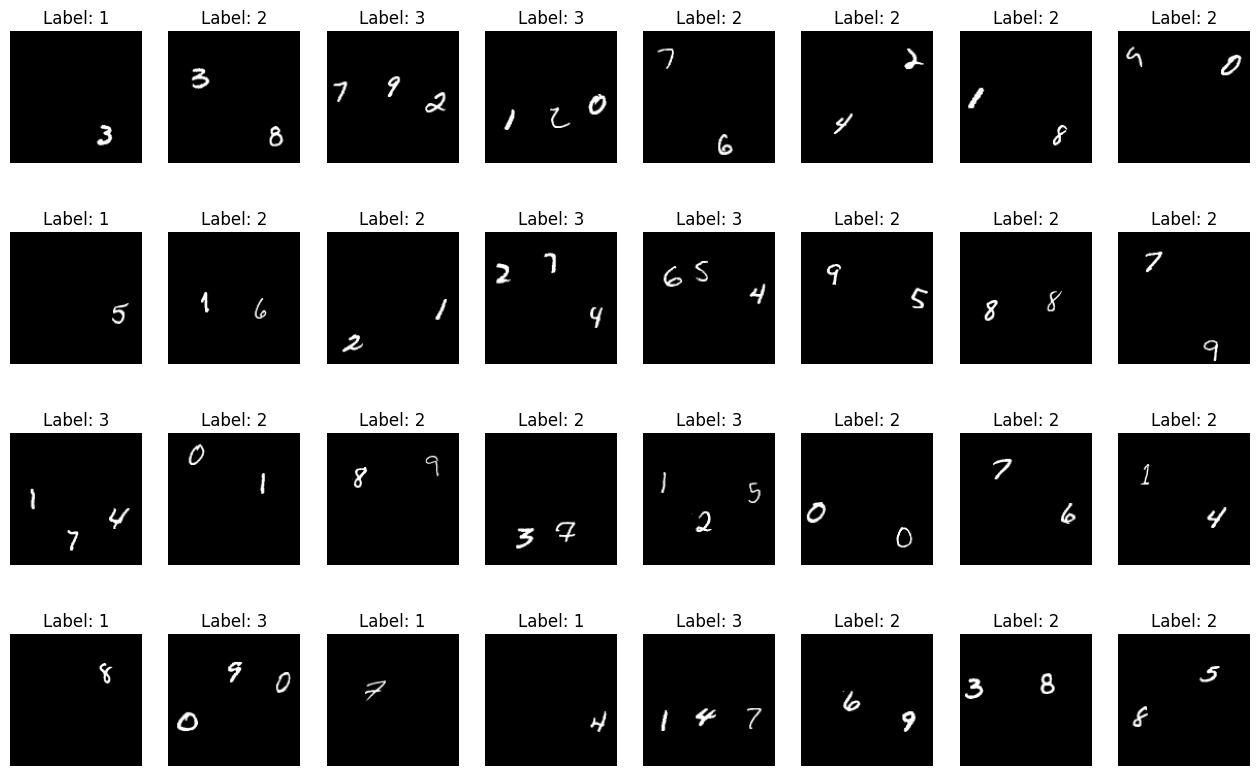

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class MultiMNISTDataset(Dataset):
    """
    Custom Dataset class for Multi-MNIST dataset. It takes in lists of images and labels
    and allows easy integration with PyTorch DataLoader.
    """
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (list of np.ndarray): List of images.
            labels (list of int): List of labels (digit counts).
            transform (callable, optional): Optional transform to be applied
                                            on an image sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.images)

    def __getitem__(self, idx):
        """Fetches a sample by index."""
        img = self.images[idx]
        label = self.labels[idx]

        # Convert image to torch tensor and normalize (if transform is not provided)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
            img = img.unsqueeze(0)  # Add channel dimension (1, H, W)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Example usage
train_images, train_labels = data['train']
print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
train_dataset = MultiMNISTDataset(train_images, train_labels)

test_images, test_labels = data['test']
print(f"Test: {len(test_images)} images, {len(test_labels)}")
test_dataset = MultiMNISTDataset(test_images, test_labels)

val_images, val_labels = data['val']
print(f"Val: {len(val_images)} images, {len(val_labels)}")
val_dataset = MultiMNISTDataset(val_images, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check a batch
for imgs, labels in train_loader:
    print(f"Batch of images: {imgs.shape}")
    print(f"Batch of labels: {labels}")
    
    # Visualize all 32 images in the batch
    plt.figure(figsize=(16, 10))
    for i in range(32):
        img = imgs[i][0].numpy()
        label = labels[i].item()
        plt.subplot(4, 8, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()
    
    break

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define CNN model
class DigitCountCNN(nn.Module):
    def __init__(self, num_classes=4):  # Assuming 4 classes: 0, 1, 2, 3 digits
        super(DigitCountCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Instantiate model and move it to GPU
model = DigitCountCNN(num_classes=4).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with CUDA support
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):  # Assuming train_loader is defined
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print statistics
        if (batch_idx + 1) % 100 == 0:    # Print every 100 mini-batches
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Step [{batch_idx+1}], '
                  f'Loss: {running_loss/100:.4f}')
            running_loss = 0.0

    # Optional: Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:  # Assuming valid_loader is defined
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'digit_count_model.pth')

Using device: cuda
Epoch [1/10], Step [100], Loss: 0.3229


KeyboardInterrupt: 

In [32]:
# Reinitialize the model architecture
model = DigitCountCNN(num_classes=4).to(device)
model.load_state_dict(torch.load('digit_count_model.pth'))
# model = torch.load('digit_count_model.pth')

/tmp/ipykernel_159655/2185492603.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('digit_count_model.pth'))


<All keys matched successfully>

In [33]:
# print the output from the model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is defined
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f"Predicted: {predicted}")
        print(f"True: {labels}")
        break  # Print only the first batch

Predicted: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DigitCountCNN(nn.Module):
    def __init__(self, num_classes=4, task='classification'):
        """
        Initialize CNN model that can perform either classification or regression
        
        Args:
            num_classes (int): Number of classes for classification
            task (str): Either 'classification' or 'regression'
        """
        super(DigitCountCNN, self).__init__()
        self.task = task.lower()
        if self.task not in ['classification', 'regression']:
            raise ValueError("Task must be either 'classification' or 'regression'")
        
        # Convolutional layers (same for both tasks)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        
        # Output layer changes based on task
        if self.task == 'classification':
            self.fc2 = nn.Linear(256, num_classes)
        else:  # regression
            self.fc2 = nn.Linear(256, 1)  # Single continuous output
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Apply activation for classification (if needed)
        if self.task == 'classification':
            # Note: We don't apply softmax here because CrossEntropyLoss includes it
            return x
        else:
            # For regression, we might want to ensure non-negative outputs
            # depending on your specific use case
            return F.relu(x)  # or just return x if negative values are acceptable

def train_model(model, train_loader, valid_loader, device, num_epochs=10, learning_rate=0.001):
    """
    Training function that handles both classification and regression
    """
    model = model.to(device)
    
    # Choose loss function based on task
    if model.task == 'classification':
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()  # or nn.L1Loss() for mean absolute error
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # For regression, reshape labels to match output
            if model.task == 'regression':
                labels = labels.float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}], '
                      f'Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        
        # Validation
        model.eval()
        with torch.no_grad():
            if model.task == 'classification':
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = 100 * correct / total
                print(f'Validation Accuracy: {accuracy:.2f}%')
            else:
                val_loss = 0.0
                for images, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.float().view(-1, 1).to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, labels).item()
                avg_val_loss = val_loss / len(valid_loader)
                print(f'Validation Loss: {avg_val_loss:.4f}')

# Example usage:
# For classification
model_cls = DigitCountCNN(num_classes=4, task='classification')
train_model(model_cls, train_loader, val_loader, device)

# For regression
model_reg = DigitCountCNN(num_classes=None, task='regression')
train_model(model_reg, train_loader, val_loader, device)

# Save model
def save_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'task': model.task
    }, path)

# Load model
def load_model(path):
    checkpoint = torch.load(path)
    model = DigitCountCNN(task=checkpoint['task'])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

Epoch [1/10], Step [100], Loss: 0.3442


KeyboardInterrupt: 

In [ ]:
# load the model


In [10]:
# print the output for the regression model
model_reg.eval()
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is defined
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)
        outputs = model_reg(images)
        print(f"Predicted: {outputs.view(-1).cpu().numpy()}")
        print(f"True: {labels.view(-1).cpu().numpy()}")
        break  # Print only the first batch

NameError: name 'model_reg' is not defined

In [34]:
class DigitCountCNN(nn.Module):
    def __init__(self, num_classes=4):  # Assuming 4 classes: 0, 1, 2, 3 digits
        super(DigitCountCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        feature_maps = {}  # Dictionary to store intermediate feature maps
        x = F.relu(self.conv1(x))
        feature_maps["conv1"] = x
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        feature_maps["conv2"] = x
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        feature_maps["conv3"] = x
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x, feature_maps


In [35]:
# Reinitialize the model architecture
model = DigitCountCNN(num_classes=4).to(device)
model.load_state_dict(torch.load('digit_count_model.pth'))
# model = torch.load('digit_count_model.pth')

/tmp/ipykernel_159655/2185492603.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('digit_count_model.pth'))


<All keys matched successfully>

In [36]:
import matplotlib.pyplot as plt

def visualize_feature_maps(model, images):
    model.eval()
    with torch.no_grad():
        for i, image in enumerate(images[:3]):  # Visualize feature maps for the first 3 images
            image = image.unsqueeze(0)  # Add batch dimension
            
            # Get predictions and feature maps
            _, feature_maps = model(image)

            # Visualize feature maps for each layer
            for layer_name, fmap in feature_maps.items():
                num_channels = fmap.size(1)
                fig, axes = plt.subplots(1, min(num_channels, 6), figsize=(15, 5))
                fig.suptitle(f'Feature Maps after {layer_name} for Image {i+1}', fontsize=16)
                
                for idx in range(min(num_channels, 6)):  # Show up to 6 feature maps per layer
                    axes[idx].imshow(fmap[0, idx].cpu().numpy(), cmap='viridis')
                    axes[idx].axis('off')
                    axes[idx].set_title(f'Channel {idx+1}')
                plt.show()


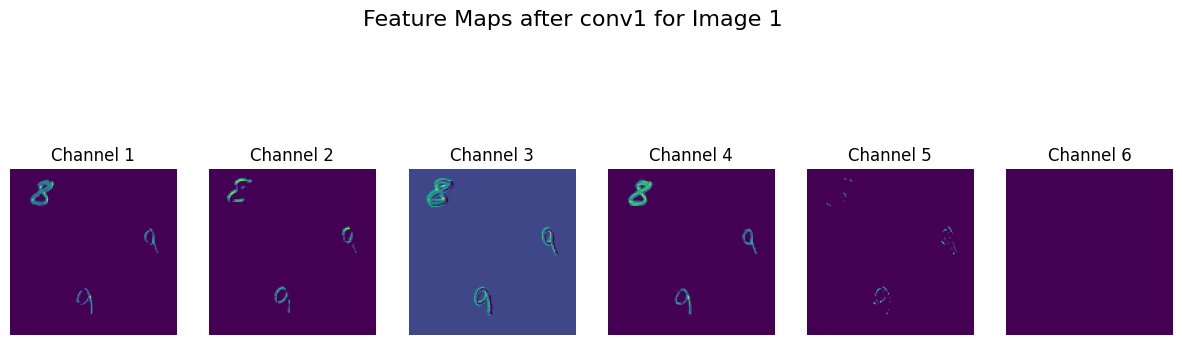

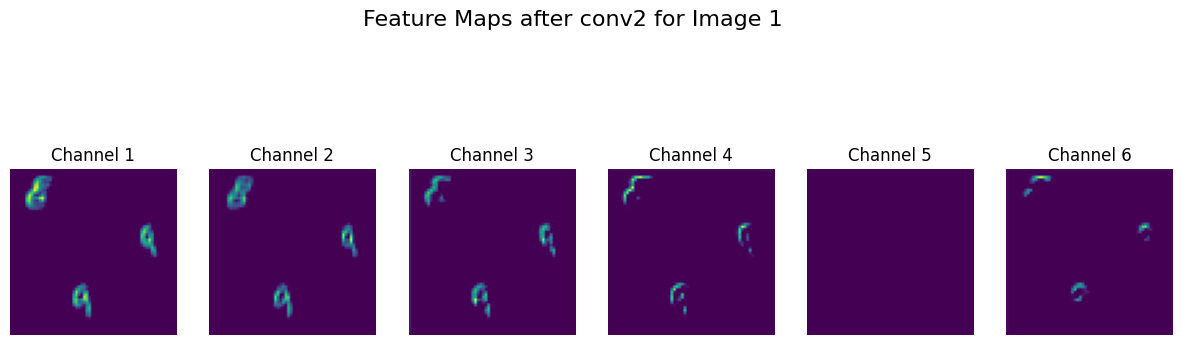

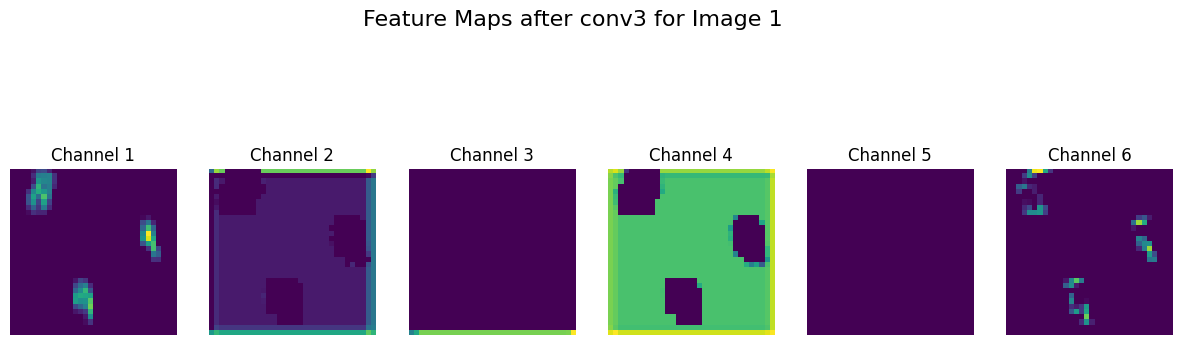

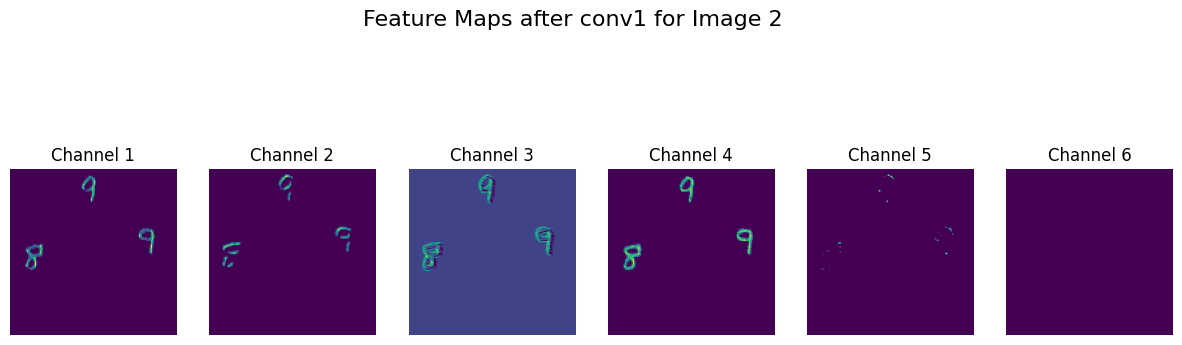

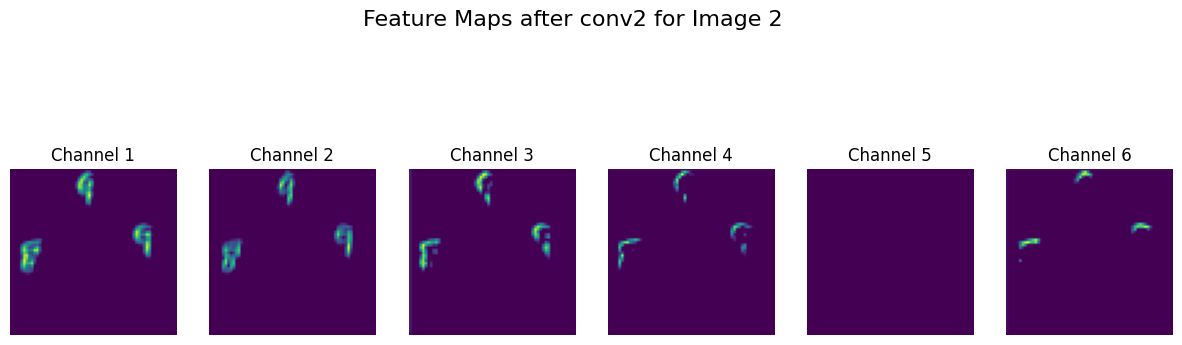

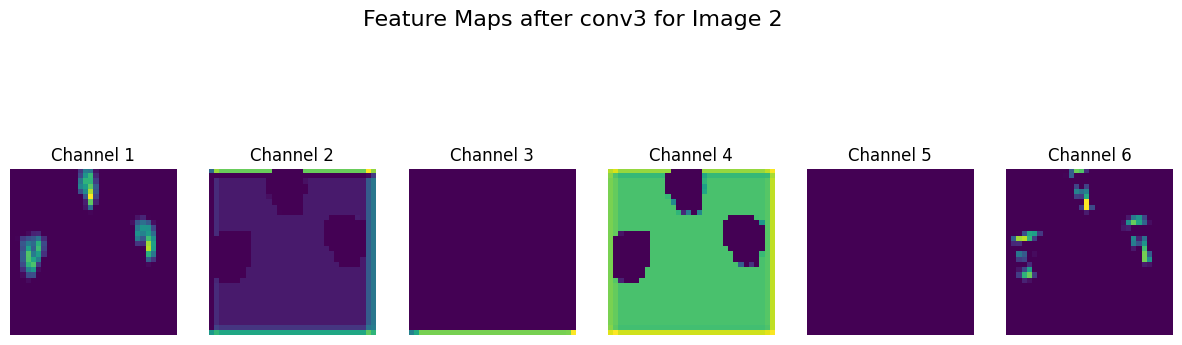

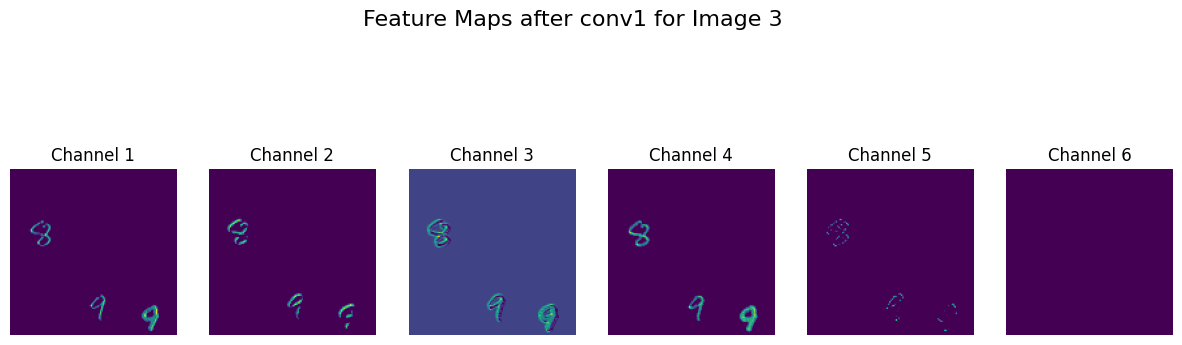

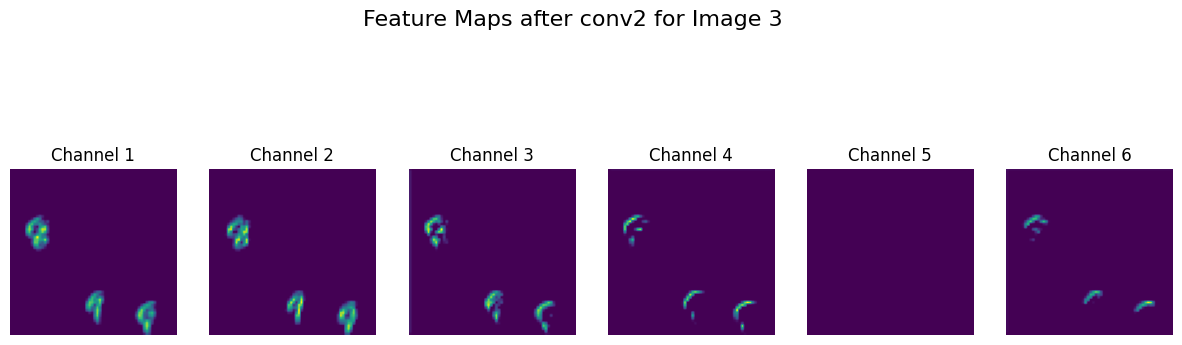

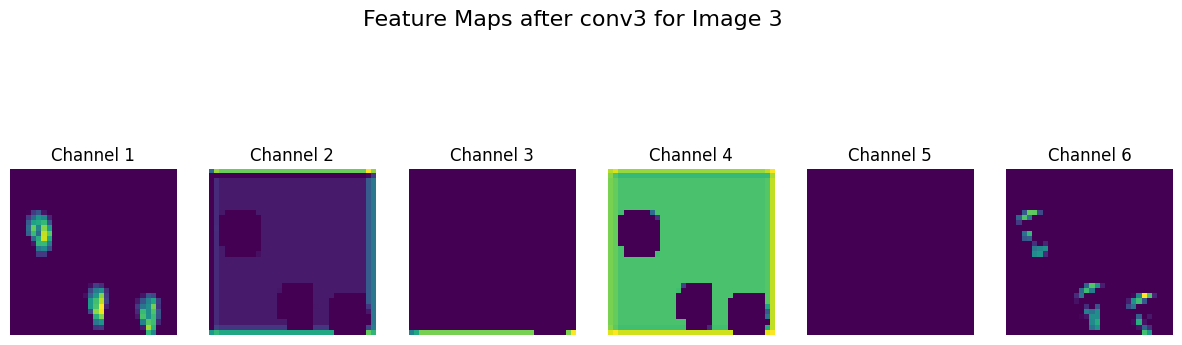

In [37]:
# Get some test images from test_loader
sample_images = []
for images, _ in test_loader:
    sample_images.extend(images)
    if len(sample_images) >= 3:  # Get at least 3 images
        break

sample_images = sample_images[:3]  # Limit to 3 images
sample_images = torch.stack(sample_images).to(device)  # Convert to tensor and move to device

# Visualize feature maps
visualize_feature_maps(model, sample_images)
